# 实战Kaggle比赛：预测房价

房价预测比赛是一个很好的起点。这个数据是相当通用的，不会需要使用带特殊结构的模型（就像音频或视频可能需要的那样）。此数据集由Bart de Cock于2011年收集 [DeCock, 2011] ，涵盖了2006-2010年期间亚利桑那州埃姆斯市的房价。

##  我们实现几个函数来方便下载数据
首先，我们维护字典DATA_HUB，其将数据集名称的字符串映射到数据集相关的**二元组**上，这个二元组包含数据集的url和验证文件完整性的sha-1密钥。所有这样的数据集都托管在地址为DATA_URL的站点上。

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下面的download函数用来下载数据集，将数据集缓存在本地目录（默认情况下为../data）中，并返回下载文件的名称。如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配，我们将使用缓存的文件，以避免重复的下载。

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

我们还实现了两个额外的实用函数：一个是下载并解压缩一个zip或tar文件，另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件。"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)

In [5]:
# 如果pandas没有被安装，请取消下一句的注释。
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

为方便起见，我们可以使用上面定义的脚本下载并缓存Kaggle房屋数据集。

In [6]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


In [8]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [14]:
print(train_data.iloc[0:10, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
4   5          60       RL         84.0       WD        Normal     250000
5   6          50       RL         85.0       WD        Normal     143000
6   7          20       RL         75.0       WD        Normal     307000
7   8          60       RL          NaN       WD        Normal     200000
8   9          50       RM         51.0       WD       Abnorml     129900
9  10         190       RL         50.0       WD        Normal     118000


我们可以看到，在每个样本中，第一个特征是ID，这有助于模型识别每个训练样本。虽然这很方便，但它不携带任何用于预测的信息。因此，在将数据提供给模型之前，我们将其从数据集中删除。

In [15]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

##  数据预处理

![image.png](https://pic.rmb.bdstatic.com/bjh/7c4bbd708467aabb14a44a8ebacae9cc.png)

In [17]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有数据都意味着消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

![image.png](https://pic.rmb.bdstatic.com/bjh/d98fb9a070dbe7e31d674c949df71590.png)

In [19]:
# `Dummy_na=True` 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征。
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

你可以看到，此转换会将特征的数量从79个增加到331个。最后，通过values属性，我们可以从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练。

In [20]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=d2l.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=d2l.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=d2l.float32)

## 训练
首先，我们训练一个带有损失平方的线性模型。毫不奇怪，我们的线性模型不会让我们在竞赛中获胜，但线性模型提供了一种健全性检查，以查看数据中是否存在有意义的信息。如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。如果一切顺利，线性模型将作为基线模型，让我们直观地知道简单的模型离报告最好的模型有多近，让我们感觉到我们应该从更酷炫的模型中获得多少收益。

In [21]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

![image.png](https://pic.rmb.bdstatic.com/bjh/1c07e74c087d865a480a2cde208f2dd1.png)

In [23]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

与前面的部分不同，我们的训练函数将借助Adam优化器。这个优化器的主要吸引力在于，**尽管在提供无限资源进行超参数优化方面没有做得更好（有时更差），但人们发现它对初始学习率不那么敏感**。

In [24]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证

注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，我们肯定会做一些更聪明的改变。但是这种改变所增加的复杂性可能会使代码看起来更乱。在这里可以忽略这些改变，因为我们的问题很简单。

In [25]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

当我们在K折交叉验证中训练K次后，返回训练和验证误差的平均值。

In [27]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 模型选择
在本例中，我们选择了一组未调优的超参数，并将其留给读者来改进模型。找到一个好的选择可能需要时间，这取决于一个人优化了多少变量。有了足够大的数据集和合理设置的超参数，K折交叉验证往往对多次测试具有相当的适应性。然而，如果我们尝试了不合理的大量选项，我们可能会发现验证效果不再代表真正的误差。

fold 1, train log rmse 0.170598, valid log rmse 0.156560
fold 2, train log rmse 0.161969, valid log rmse 0.190479
fold 3, train log rmse 0.163774, valid log rmse 0.168607
fold 4, train log rmse 0.168343, valid log rmse 0.154473
fold 5, train log rmse 0.163467, valid log rmse 0.183103
5-折验证: 平均训练log rmse: 0.165630, 平均验证log rmse: 0.170644


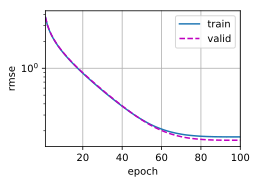

In [29]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

请注意，有时一组超参数的训练误差可能非常低，但K折交叉验证的误差要高得多。这表明我们过拟合了。在整个训练过程中，你将希望监控训练误差和验证误差这两个数字。较少的过拟合可能表明现有数据可以支撑一个更强大的模型。较大的过拟合可能意味着我们可以通过正则化技术来获益。

## 提交你的Kaggle预测
既然我们知道应该选择什么样的超参数，我们不妨使用所有数据对其进行训练（而不是仅使用交叉验证中使用的1−1/K的数据）。然后，我们通过这种方式获得的模型可以应用于测试集。将预测保存在CSV文件中可以简化将结果上传到Kaggle的过程。

In [30]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

一种良好的完整性检查是查看测试集上的预测是否与K倍交叉验证过程中的预测相似。如果是，那就是时候把它们上传到Kaggle了。下面的代码将生成一个名为submission.csv的文件。

train log rmse 0.162432


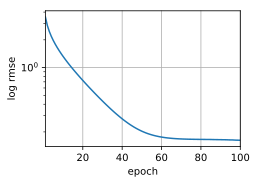

In [31]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)